<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Predicción de casos diarios de COVID-19<a id="top"></a>

<i>Última actualización: 2025-03-05</small></i></div>

***

## Introducción

## Nuevo Coronavirus (COVID-19)

La Covid-19 fue una enfermedad respiratoria muy infecciosa que se extendió por todo el planeta desde finales de 2019. A mediados de 2023, la el número adcumulado de casos de casos de coronavirus es una enfermedad se ha extendido rápidamente por todo el mundo. En el periodo de estudio del 22 de enero de 2020 al 2 de agosto de 2023 [se registraron en el mundo alrededor de 769 millones de casos de SARS-CoV-2](https://es.statista.com/estadisticas/1104227/numero-acumulado-de-casos-de-coronavirus-covid-19-en-el-mundo-enero-marzo/).

### ¿Cómo de peligroso era?

Pues era una enfermedad muy contagiosa, pero no era especialmente letal. En [worldometers](https://www.worldometers.info/coronavirus/worldwide-graphs/) existe un listado de indicadores con la progresión desde primcippios de 2020 hasta el 13 de abril de 2024 que dejaron de actualizarlo. En general, las personas mayores y las personas con enfermedades crónicas graves tenían más probabilidades de morir a causa de la Covid-19, por ello era importante proteger a estos grupos de riesgo, [aunque en algunas capitales de España no se pensase lo mismo](https://www.imdb.com/es/title/tt35097841/).

## Objetivos

Crearemos un modelo de regresión para predecir el número de casos diarios de Covid-19 a partir de datos históricos, utilizando redes neuronales recurrentes. Concretamente:

- Manipularemos datos de series temporales para adecuarlos a nuestros modelos.
- Implementaremos y entrenaremos modelos de regresión basados en `RNN`, `LSTM` y `GRU`.
- Los compararemos y evaluaremos sy desempeño utilizando métricas específicas para series temporales.

## Bibliotecas y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del cuaderno.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import torchmetrics

import utils

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Por último, establecemos las constantes de los recursos comunes.

In [4]:
BATCH_SIZE = 1024
TRAIN_EPOCHS = 100
SEQUENCE_LEN = 10

***

## Carga y preparación de datos

Descargaremos todo el dataset, que se encuentra alojado en el repositorio oficial del CSSE de Johns Hopkins.

In [5]:
repo = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19"
dataset = "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(f"{repo}/refs/heads/master/{dataset}")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


Para este ejemplo vamos a prescindir de la información relacionada con la localización (las cuatro primeras columnas).

In [6]:
df = df.iloc[:, 4:]  # Off with the first 4 columns

 También, dado que lo que queremos predecir es el número de casos diarios y que la información que aparece es el acumulado, debemos calcular la diferencia entre días consecutivos. Para ello primero debemos asegurarnos de que no hay valores nulos en el dataset. Así que comprobaremos que no los hay y sacaremos los valores acumulados.

2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
dtype: int64


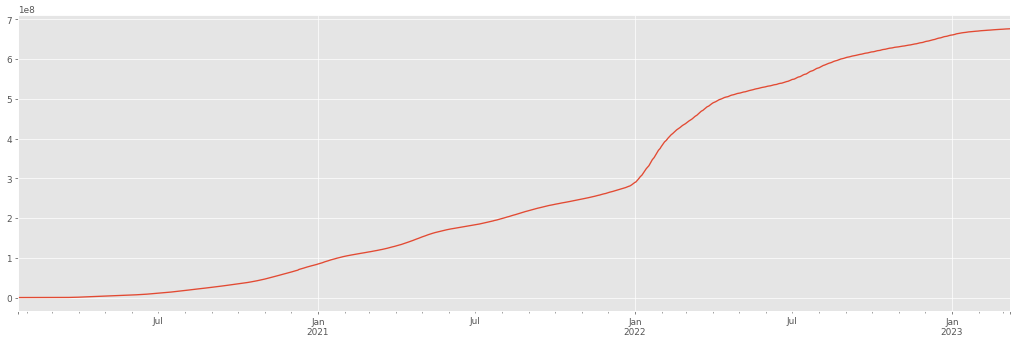

In [7]:
assert df.isnull().sum().sum() == 0  # No null values, please

df = df.sum(axis=0)
df.index = pd.to_datetime(df.index, format='mixed')
print(df.head())
df.plot();

Ahora, este conjunto de datos acumulados por día se lo restaremos a nuestro conjunto de datos para que nos quede la diferencia entre días consecutivos, que es lo que queremos predecir. Nos quedamos con el primer valor de la  secuencia porque no tenemos el valor anterior para calcular la diferencia.

/tmp/ipykernel_297065/3415012804.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df = df.diff().fillna(df[0]).astype(np.int64)


2020-01-22    557
2020-01-23    100
2020-01-24    287
2020-01-25    493
2020-01-26    683
dtype: int64


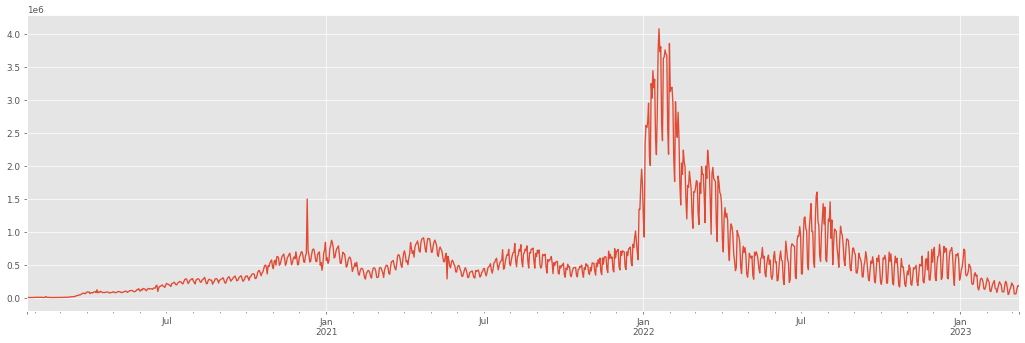

In [8]:
df = df.diff().fillna(df[0]).astype(np.int64)
print(df.head())
df.plot();

Ya tenemos la serie temporal con la que vamos a trabajar. Ahora vamos a dividir los datos en entrenamiento y test. Para ello vamos a utilizar los datos de los primeros $80\%$ días para entrenar y el resto para test.

In [9]:
test_size = int(len(df) * .2)

train_data = df[:-test_size]
test_data  = df[-test_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape:  {test_data.shape}")

Train data shape: (915,)
Test data shape:  (228,)


Estos datos los estandarizaremos para que tengan media $0$ y desviación estándar $1$. Para ello utilizaremos `StandardScaler` de `sklearn`.

In [10]:
scaler = sklearn.preprocessing.StandardScaler()
scaler = scaler.fit(train_data.to_numpy().reshape(-1, 1))

train_data = scaler.transform(train_data.to_numpy().reshape(-1, 1))
test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape:  {test_data.shape}")

Train data shape: (915, 1)
Test data shape:  (228, 1)


Ahora, toda la secuencia será transformada en secuencias de longitud `n_steps` para que podamos entrenar nuestros modelos. Para ello utilizaremos la función `split_sequence` que definiremos a continuación.

In [11]:
def split_sequence(data, n_steps):
    X, y = [], []

    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])

    return np.array(X), np.array(y)

x_train, y_train = split_sequence(data=train_data, n_steps=SEQUENCE_LEN)
x_test, y_test = split_sequence(data=test_data, n_steps=SEQUENCE_LEN)

print(f"Train data shape -> input: {x_train.shape}, output: {y_train.shape}")
print(f"Test data shape  -> input: {x_test.shape}, output: {y_test.shape}")

Train data shape -> input: (905, 10, 1), output: (905, 1)
Test data shape  -> input: (218, 10, 1), output: (218, 1)


Para finalizar, trabajaremos similar a  como trabajábamos en el resto de ejemplos, así que crearemos una subclase de `torch.utils.data.Dataset` iterar sobre los datos de entrenamiento y test.

In [12]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

## Definición de los modelos

Ahora pasaremos a definir nuestros modelos. Concretamente, implementaremos tres modelos basados en redes neuronales recurrentes: `RNN`, `LSTM` y `GRU`.

In [13]:
class RNNModel(torch.nn.Module):
    def __init__(self, n_in, n_hid, n_layers, n_out, rnn_cls, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = rnn_cls(
            input_size=n_in,
            hidden_size=n_hid,
            num_layers=n_layers,  # Esto es otra forma de apilar varias RNN
            batch_first=True,
        )
        self.fc = torch.nn.Linear(in_features=n_hid, out_features=n_out)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_features = 1
hidden_units = 16
num_layers = 2
output_size = 1

rnn_model = RNNModel(
    n_in=input_features,
    n_hid=hidden_units,
    n_layers=num_layers,
    n_out=output_size,
    rnn_cls=torch.nn.RNN,
)

gru_model = RNNModel(
    n_in=input_features,
    n_hid=hidden_units,
    n_layers=num_layers,
    n_out=output_size,
    rnn_cls=torch.nn.GRU,
)

lstm_model = RNNModel(
    n_in=input_features,
    n_hid=hidden_units,
    n_layers=num_layers,
    n_out=output_size,
    rnn_cls=torch.nn.LSTM,
)

Ahora, entrenaremos el modelo con los datos de entrenamiento que hemos preparado.

In [14]:
print("Training RNN model ... ", end="")
history_rnn = utils.train(
    model=rnn_model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam(rnn_model.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.MeanAbsoluteError(),
    verbose=False,
)
print("Results:")
avg_trn_loss = np.mean(history_rnn.get("train_loss"))
avg_val_loss = np.mean(history_rnn.get("val_loss"))
avg_trn_metr = np.mean(history_rnn.get("train_metric"))
avg_val_metr = np.mean(history_rnn.get("val_metric"))
print(f"- Train loss: {avg_trn_loss} - Validation loss: {avg_val_loss}")
print(f"- Train metric: {avg_trn_metr} - Validation metric: {avg_val_metr}")

print("Training GRU model ...", end="")
history_gru = utils.train(
    model=gru_model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam(gru_model.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.MeanAbsoluteError(),
    verbose=False,
)
print("Results:")
avg_trn_loss = np.mean(history_rnn.get("train_loss"))
avg_val_loss = np.mean(history_rnn.get("val_loss"))
avg_trn_metr = np.mean(history_rnn.get("train_metric"))
avg_val_metr = np.mean(history_rnn.get("val_metric"))
print(f"- Train loss: {avg_trn_loss} - Validation loss: {avg_val_loss}")
print(f"- Train metric: {avg_trn_metr} - Validation metric: {avg_val_metr}")

print("Training LSTM model ...", end="")
history_lstm = utils.train(
    model=lstm_model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam(lstm_model.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.MeanAbsoluteError(),
    verbose=False,
)
print(" OK")
print("Results for RNN:")
avg_trn_loss = np.mean(history_rnn.get("train_loss"))
avg_val_loss = np.mean(history_rnn.get("val_loss"))
avg_trn_metr = np.mean(history_rnn.get("train_metric"))
avg_val_metr = np.mean(history_rnn.get("val_metric"))
print(f"- Train loss: {avg_trn_loss} - Validation loss: {avg_val_loss}")
print(f"- Train metric: {avg_trn_metr} - Validation metric: {avg_val_metr}")

Training RNN model ... Results:
- Train loss: 0.313450538367033 - Validation loss: 0.6438209223747253
- Train metric: 0.30937753289937975 - Validation metric: 0.4128658884763718
Results: GRU model ...
- Train loss: 0.313450538367033 - Validation loss: 0.6438209223747253
- Train metric: 0.30937753289937975 - Validation metric: 0.4128658884763718
 OKining LSTM model ...
Results for RNN:
- Train loss: 0.313450538367033 - Validation loss: 0.6438209223747253
- Train metric: 0.30937753289937975 - Validation metric: 0.4128658884763718


Echemos un vistazo a la evolución del entrenamiento.

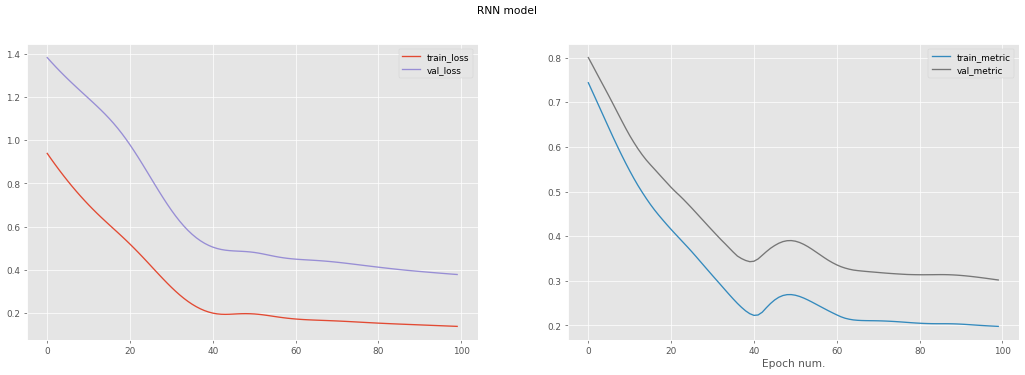

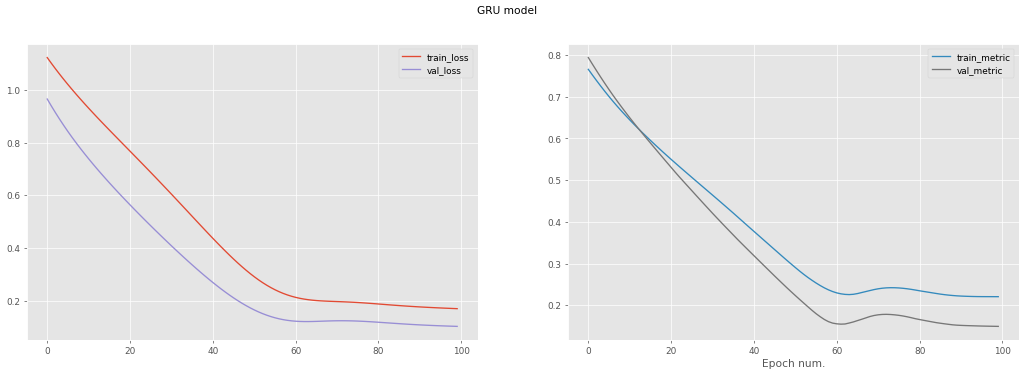

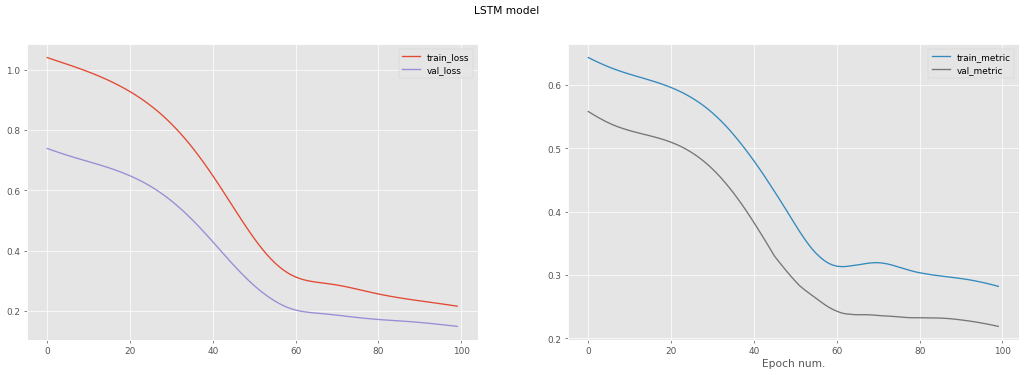

In [15]:
pd.DataFrame(history_rnn).plot(
    title='RNN model',
    subplots=[('train_loss', 'val_loss'), ('train_metric', 'val_metric')],
    layout=(1, 2),
)
plt.xlabel('Epoch num.')
plt.show()

pd.DataFrame(history_gru).plot(
    title='GRU model',
    subplots=[('train_loss', 'val_loss'), ('train_metric', 'val_metric')],
    layout=(1, 2),
)
plt.xlabel('Epoch num.')
plt.show()

pd.DataFrame(history_lstm).plot(
    title='LSTM model',
    subplots=[('train_loss', 'val_loss'), ('train_metric', 'val_metric')],
    layout=(1, 2),
)
plt.xlabel('Epoch num.')
plt.show()

## Evaluación del modelo

Tras el entrenamiento, ya podemos evaluar el rendimiento de cada modelo sobre el conjunto de prueba.

In [16]:
print("Evaluating RNN model ...", end="")
eval_rnn = utils.evaluate(
    model=rnn_model,
    data_loader=test_loader,
    criterion=torch.nn.MSELoss(),
    metric_fn=torchmetrics.MeanAbsoluteError(),
)
print(" OK")
print("Evaluating GRU model ...", end="")
eval_gru = utils.evaluate(
    model=gru_model,
    data_loader=test_loader,
    criterion=torch.nn.MSELoss(),
    metric_fn=torchmetrics.MeanAbsoluteError(),
)
print(" OK")
print("Evaluating LSTM model ...", end="")
eval_lstm = utils.evaluate(
    model=lstm_model,
    data_loader=test_loader,
    criterion=torch.nn.MSELoss(),
    metric_fn=torchmetrics.MeanAbsoluteError(),
)
print(" OK")

print(f'Results for RNN  -> Loss: {eval_rnn.get("loss")}, metric: {eval_rnn.get("metric")}')
print(f'Results for GRU  -> Loss: {eval_gru.get("loss")}, metric: {eval_gru.get("metric")}')
print(f'Results for LSTM -> Loss: {eval_lstm.get("loss")}, metric: {eval_lstm.get("metric")}')

Evaluating RNN model ... OK
Evaluating GRU model ... OK
Evaluating LSTM model ... OK
Results for RNN  -> Loss: 0.1628594994544983, metric: 0.20780010521411896
Results for GRU  -> Loss: 0.1629735380411148, metric: 0.21348661184310913
Results for LSTM -> Loss: 0.20786966383457184, metric: 0.27425694465637207


Al menos no es un comportamiento como el anterior. Pero sigue siendo inútil. Aparentemente no vamos a hacernos ricos, al menos no así.

## Conclusiones

En este notebook hemos desarrollado y entrenado tres modelos de redes neuronales recurrentes utilizando PyTorch, con el objetivo de predecir el número diario de casos confirmados de COVID-19. Hemos visto cómo:

- Se pueden preprocesar y transformar datos reales de series temporales para adaptarlos al modelo,
- Es posible implementar distintos modelos en PyTorch con el mismo conjunto de datos, y

Aunque la predicción de fenómenos epidemiológicos es un desafío debido a la complejidad y la naturaleza cambiante de los datos, al menos este ejercicio nos ha ayudado a la entender de qué manera se puede trabajar con este tipo de modelos.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>